# Mode-Turbulence Coupling: Numerical Analysis
# Plots for paper

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate
from scipy.integrate import RK45
import statistics

### Physical Parameters

In [2]:
# mach number Ma
Ma = 0.1
K = 1
eta = 1

# time step d_tau
d_tau = .01

### Functions of Ma

In [3]:
meandeltaT = 2*np.pi

# variables for generating F1
meanF1 = 0
stdF1 = Ma**3 / (2 * np.pi)
limitF1 = eta * Ma**2 / (2 * np.pi)

# variables for generating F2
meanF2 = 0
stdF2 = Ma**2
limitF2 = eta * Ma**2

### Calculation parameters

In [4]:
L = 10
M = 10**3
N = 1
m = 100

# h is the time step for the Runge Kutta Method
h = 2*np.pi/100
Tr = K * meandeltaT

### Calculation relations

In [5]:
# Tmax = 2 * pi * M
# delt = N * deltaT

### Initial Conditions

In [6]:
# initial conditions A(0)=1/2*std_F2, dA/dT(0)=0
initial_dAdT = 0
initial_AT = 0

In [7]:
n_bins = 200

axis_font = {'size':'30'}
title_font = {'size':'40'}

### Functions

In [8]:
# Source: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.rayleigh.html
#deltaT is the length of each eddy turnover
def fundeltaT(n_bins, M):
    deltaT = []
    rayleigh = np.random.rayleigh(meandeltaT, M)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    # ensure that deltaT is a multiple of d_tau
    for i in range(M):
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)
        if (deltaTtemp % d_tau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % d_tau)
        else:
            deltaTtemp2 = deltaTtemp + d_tau - (deltaTtemp % d_tau)
        deltaT.append(deltaTtemp2)
    count, bins, ignored = plt.hist(rayleigh, 80, density=True)
    plt.title("Rayleigh Distribution")
    plt.xlabel("Delta T")
    plt.show()
    return deltaT

# Source: https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/

# Tturb adds up the delta T's
def funTturb():
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    time=Tturb
    time.pop(-1)
    return Tturb, time

def funF1():
    time = []
    y = 0
    F1 = []
    for i in range(len(deltaT)-1):
        Tn = (deltaT[i]+deltaT[i+1]/2)
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * stdF1 ** 2) ** (1/2)
        meant = math.exp(-Tn / Tr) * y
        # y is chosen from markov conditional probability function
        y = np.random.normal(meant, stdevt, 2)[0]
        Ttemp = np.linspace(0, deltaT[i], deltaT[i]/d_tau)
        # loops through each eddy
        for j in Ttemp:
            x = j / deltaT[i][0]
            if j == deltaT[i]:
                pass
            else:
                time.append(j+Tturb[i])
                F1.append(16 * y * x**2 * (1 - x)**2)
    return F1, time
    
def funF2():
    time = []
    y = 0
    F2 = []
    for i in range(len(deltaT)-1):
        Tn = (deltaT[i]+deltaT[i+1]/2)
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * stdF2 ** 2) ** (1/2)
        meant = math.exp(-Tn / Tr) * y
        # y is chosen from markov conditional probability function
        y = np.random.normal(meant, stdevt, 2)[0]
        Ttemp = np.linspace(0, deltaT[i], deltaT[i]/d_tau)
        # loops through each eddy
        for j in Ttemp:
            x = j / deltaT[i][0]
            if j == deltaT[i]:
                pass
            else:
                time.append(j+Tturb[i])
                F2.append(16 * y * x**2 * (1 - x)**2)
    return F2, time

# set G1 = 0
def funG1(F1):
    G1=[]
    for i in range(len(F1)):
        G1.append(0)
    return G1

In [9]:
def funt():
    t=[]
    for i in range(len(deltaT)-1):
        t.append((deltaT[i])/2+(deltaT[i+1])/2)
    return t

def funAmp(dAdT, AT):

    #A is the amplitude
    A=[]
    #t is time
    t=[]
    #derivA is the derivative of A with respect to time
    derivA=[]
    f1=[]
    g1=[]
    f2=[]
    
    #F2=constant=c
    #1+G1=constant=b
    #F1=constant=a
    ## a**2<4*b is always the case
    for i in range(len(Tturb)-1):
        a=F1[i]
        b=G1[i]+1
        c=F2[i]
        q=1/2*(4*b-a**2)**(1/2)
        
        C0=(math.exp(a*Tturb[i]/2)*dAdT+(a/2+q*math.tan(q*Tturb[i]))*(AT-c/b)*(math.exp(a*Tturb[i]/2)))*(math.cos(q*Tturb[i])/q)
        C0prime=math.exp(-a*Tturb[i]/2)*C0
        C1=(AT-c/b)*math.exp(a*Tturb[i]/2)/math.cos(q*Tturb[i])-C0*math.tan(q*Tturb[i])
        C1prime=math.exp(-a*(Tturb[i])/2)*C1
        
                
        #Ttemp is an array containing the times between each eddy turnover 
        #(which starts at 0 and ends at deltaT)
        Ttemp=np.linspace(0, deltaT[i])
        
        #this for loop below loops through each eddy turnover:
        for j in Ttemp:
            if j==Tturb[i]:
                pass
            else:
                t.append(Tturb[i]+j)
                f1.append(a)
                g1.append(b-1)
                f2.append(c)
                
                A.append(math.exp(-a*j/2)*(C0prime*math.sin(q*(Tturb[i]+j))+C1prime*math.cos(q*(Tturb[i]+j)))+c/b)
                derivA.append(math.exp(-a*j/2)*((C0prime*q-C1prime*a/2)*math.cos(q*(Tturb[i]+j))-(C0prime*a/2+C1prime*q)*math.sin(q*(Tturb[i]+j))))
                
        #resets the initial conditions for the next eddy turnovers to match the conditions at the end of the previous eddy turnover
        dAdT=derivA[-1]
        AT=A[-1]
    next_dAdT=derivA[-1]
    next_AT=A[-1]
            
    
    return A, t, f1, g1, f2, next_dAdT, next_AT

In [10]:
# Average value of Amplitude
def FunAsqr(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    return Asqr

# log(A)
def FunLog(A):
    logA = []
    for i in A:
        logA.append(math.log10(abs(i)))
    return logA

# Root mean square
def FunRMS(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    avg = np.sum(Asqr) / len(Asqr)
    RMS = avg**(1/2)
    return RMS
    

In [11]:
def Funplots(t, A, f1, f2):

    plt.figure(figsize=(40,10))    
    plt.plot(t, f1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.ticklabel_format(style='sci', axis = 'both', scilimits=(0,0))
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2081', **axis_font)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(40,10))
    plt.plot(t, A, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.ticker.ScalarFormatter(set_scientific(self, b))
    #plt.ticklabel_format(style='sci', axis = 'both', scilimits=(0,0))
    #plt.rcParams['font.size']=7
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(40,10))
    plt.plot(t, f2, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    #plt.ticklabel_format(style='sci', axis = 'both', scilimits=(0,0))
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2082', **axis_font)
    plt.tight_layout()
    plt.show()

### Parameters

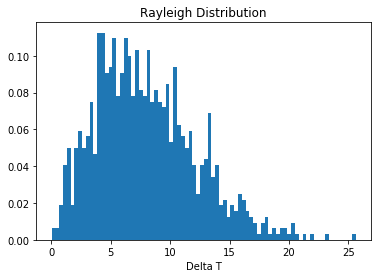

In [12]:
deltaT = fundeltaT(n_bins, M)

Tturb, time = funTturb()

t = funt()

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


<F2^2>^(1/2) =  0.0062804585111151615
Average Value of F2  0.00013730452637010274
Maximum Value of F2  0.03469627306222562
Minimum Value of F2  -0.03426938515456809


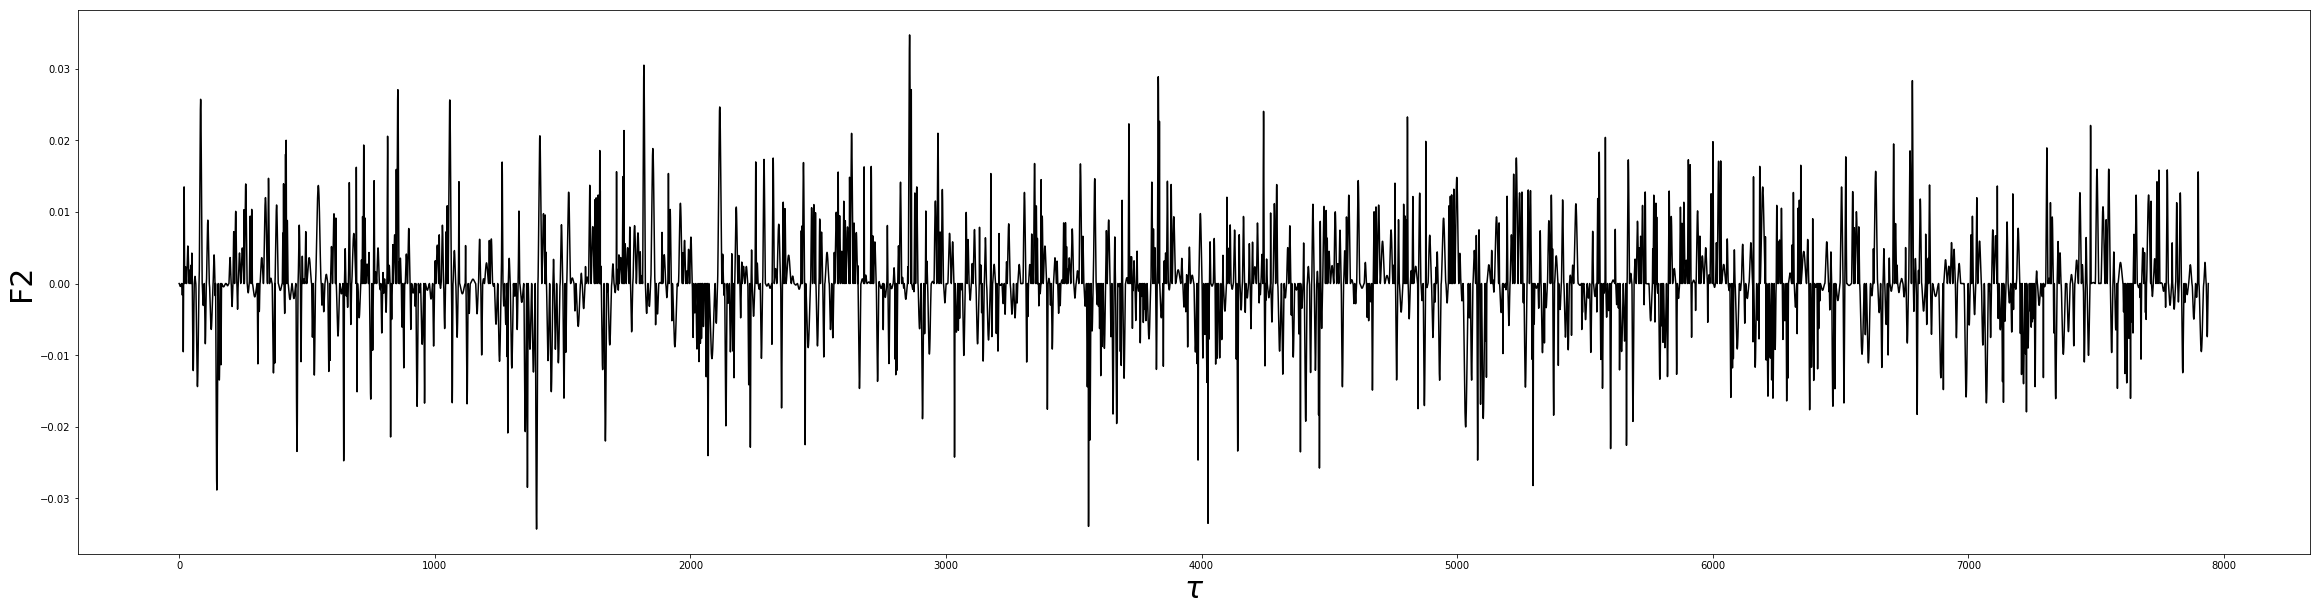

In [13]:
plt.figure(figsize=(40,10))
F2, time = funF2()
plt.plot(time, F2, 'k')
plt.xlabel(r'$\tau$', **axis_font)
plt.ylabel('F2', **axis_font)

F2sqr=[]
for i in range(len(F2)-1):
    F2sqr.append(F2[i]**2)

rms=(sum(F2sqr) / len(F2sqr) )**(1/2)
print("<F2^2>^(1/2) = ", rms)
avgF2 = sum(F2) / len(F2)
print("Average Value of F2 ", avgF2)
print("Maximum Value of F2 ", max(F2))
print("Minimum Value of F2 ", min(F2))

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


<F1^2>^(1/2) =  0.000105707016816065
Average Value of F1  -1.2400181125283847e-06
Maximum Value of F2  0.0005226106585807636
Minimum Value of F1  -0.0006517100065220893


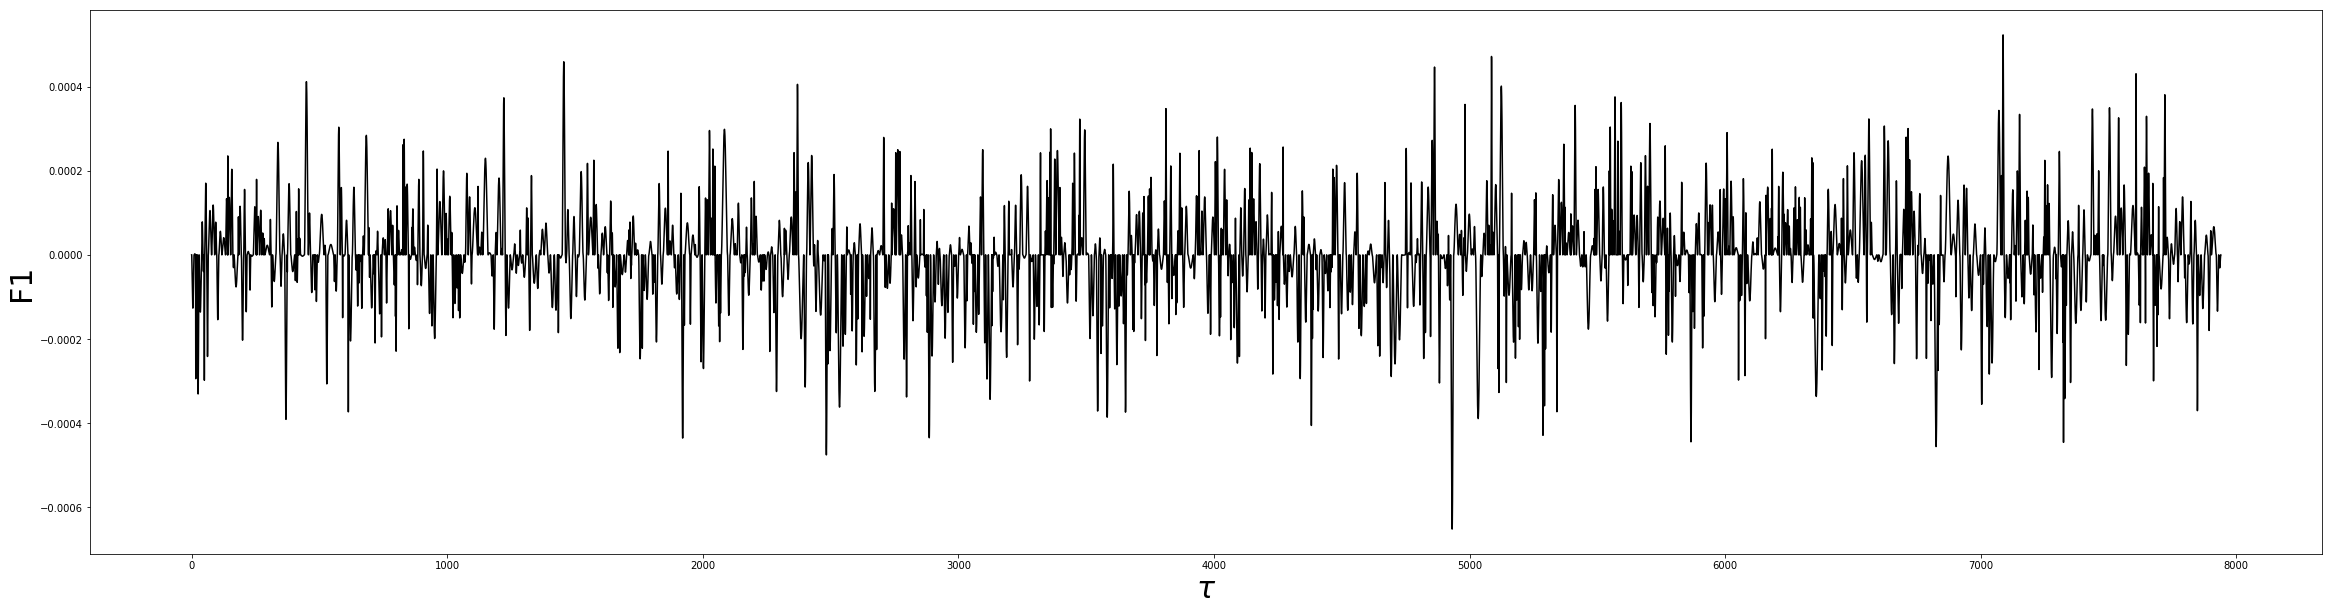

In [14]:
F1, time =funF1()
plt.figure(figsize=(40,10))
plt.plot(time, F1, 'k')
plt.xlabel(r'$\tau$', **axis_font)
plt.ylabel('F1', **axis_font)

F1sqr=[]
for i in range(len(F1)-1):
    F1sqr.append(F1[i]**2)

rms=(sum(F1sqr) / len(F1sqr) )**(1/2)
print("<F1^2>^(1/2) = ", rms)

avgF1 = sum(F1) / len(F1)
print("Average Value of F1 ", avgF1)
print("Maximum Value of F2 ", max(F1)) 
print("Minimum Value of F1 ", min(F1))

In [15]:
G1 = funG1(F1)

##  Amplitude of mode, F1, F2, log(A) vs. Time

In [16]:
# Runge Kutta

# A'' = f(T, A, A') = -F1 * A' - A + F2
# A' = u
# u' = f(T, A, u) = -F1 * u - A + F2
# A(0) = 1/2*stdF2
# A'(0) = 0

t = 0.0
A = 1/2 * stdF2
u = 0

Amp = [initial_AT]

for i in range(len(time)):
    m1 = u
    k1 = -(F1[i] * u) - A + F2[i]
    m2 = u + (h / 2.) * k1
    t_2 = t + (h / .2)
    A_2 = A + (h / .2) * m1
    u_2 = m2
    k2 = -(F1[i] * u_2) - A_2 + F2[i]
    m3 = u + (h / .2) * k2
    t_3 = t + (h / .2)
    A_3 = A + (h / .2) * m2
    u_3 = m3
    k3 = -(F1[i] * u_3) - A_3 + F2[i]
    m4 = u + h *k3
    t_4 = t + h
    A_4 = A + h * m3
    u_4 = m4
    k4 = -(F1[i] * u_4) - A_4 + F2[i]
    t = t + h 
    A = A + (h / 6.) * (m1 + (2. * m2) + (2. * m3) + m4)
    u = u + (h / 6.) * (k1 + (2. * k2) + (2. * k3) + k4)
    Amp.append(A)

Amp = Amp[:-1]

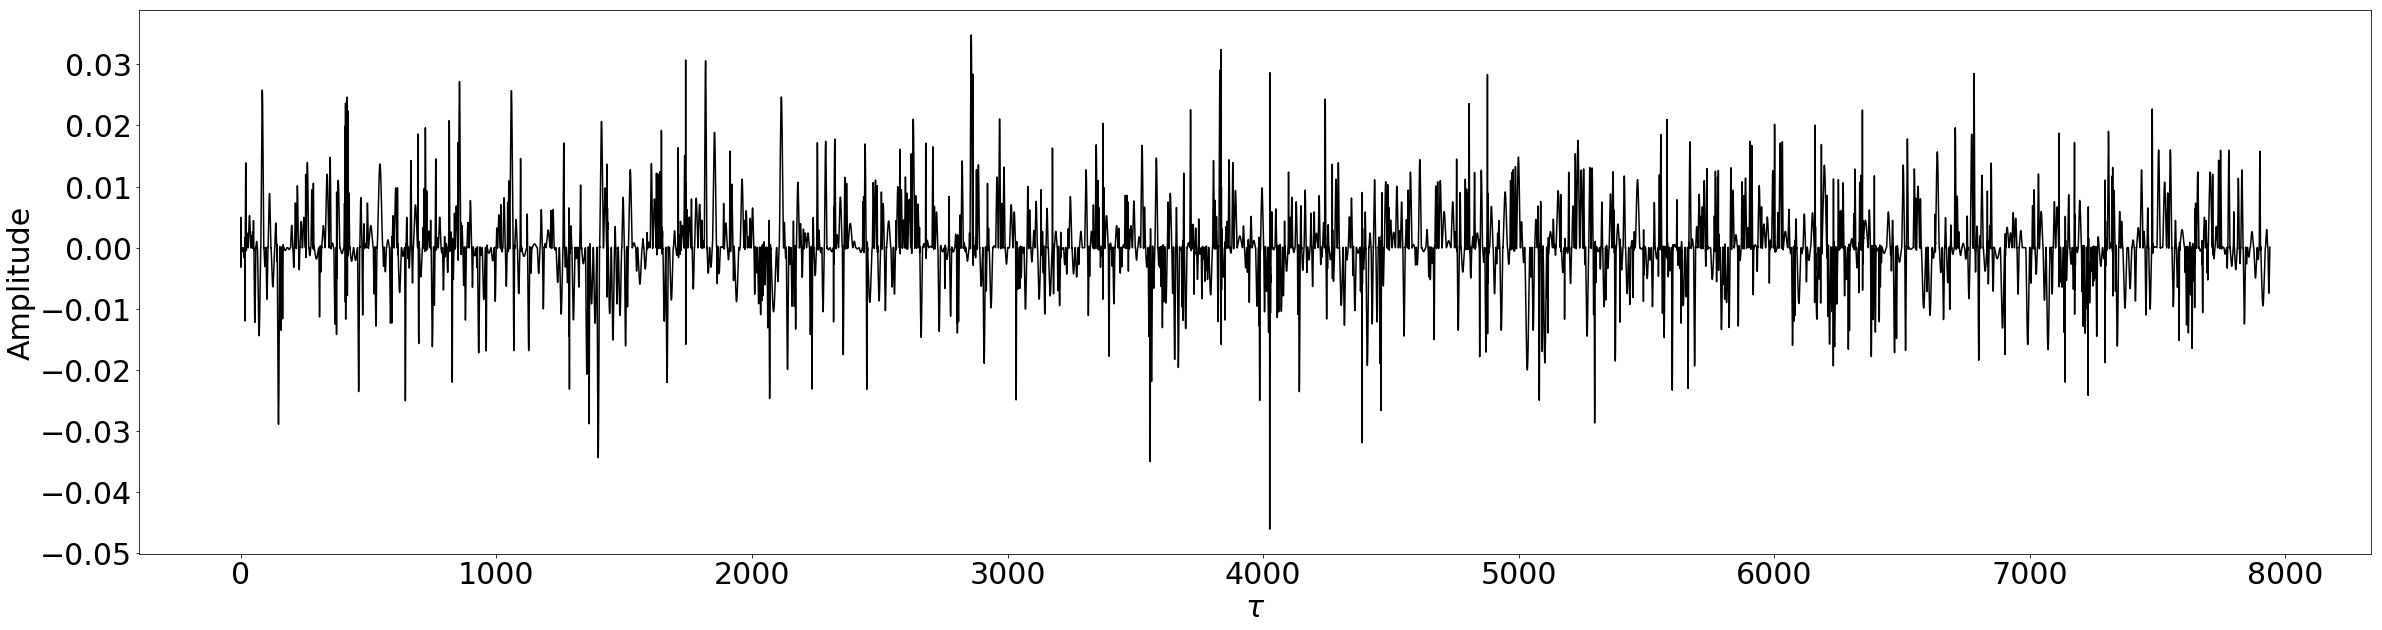

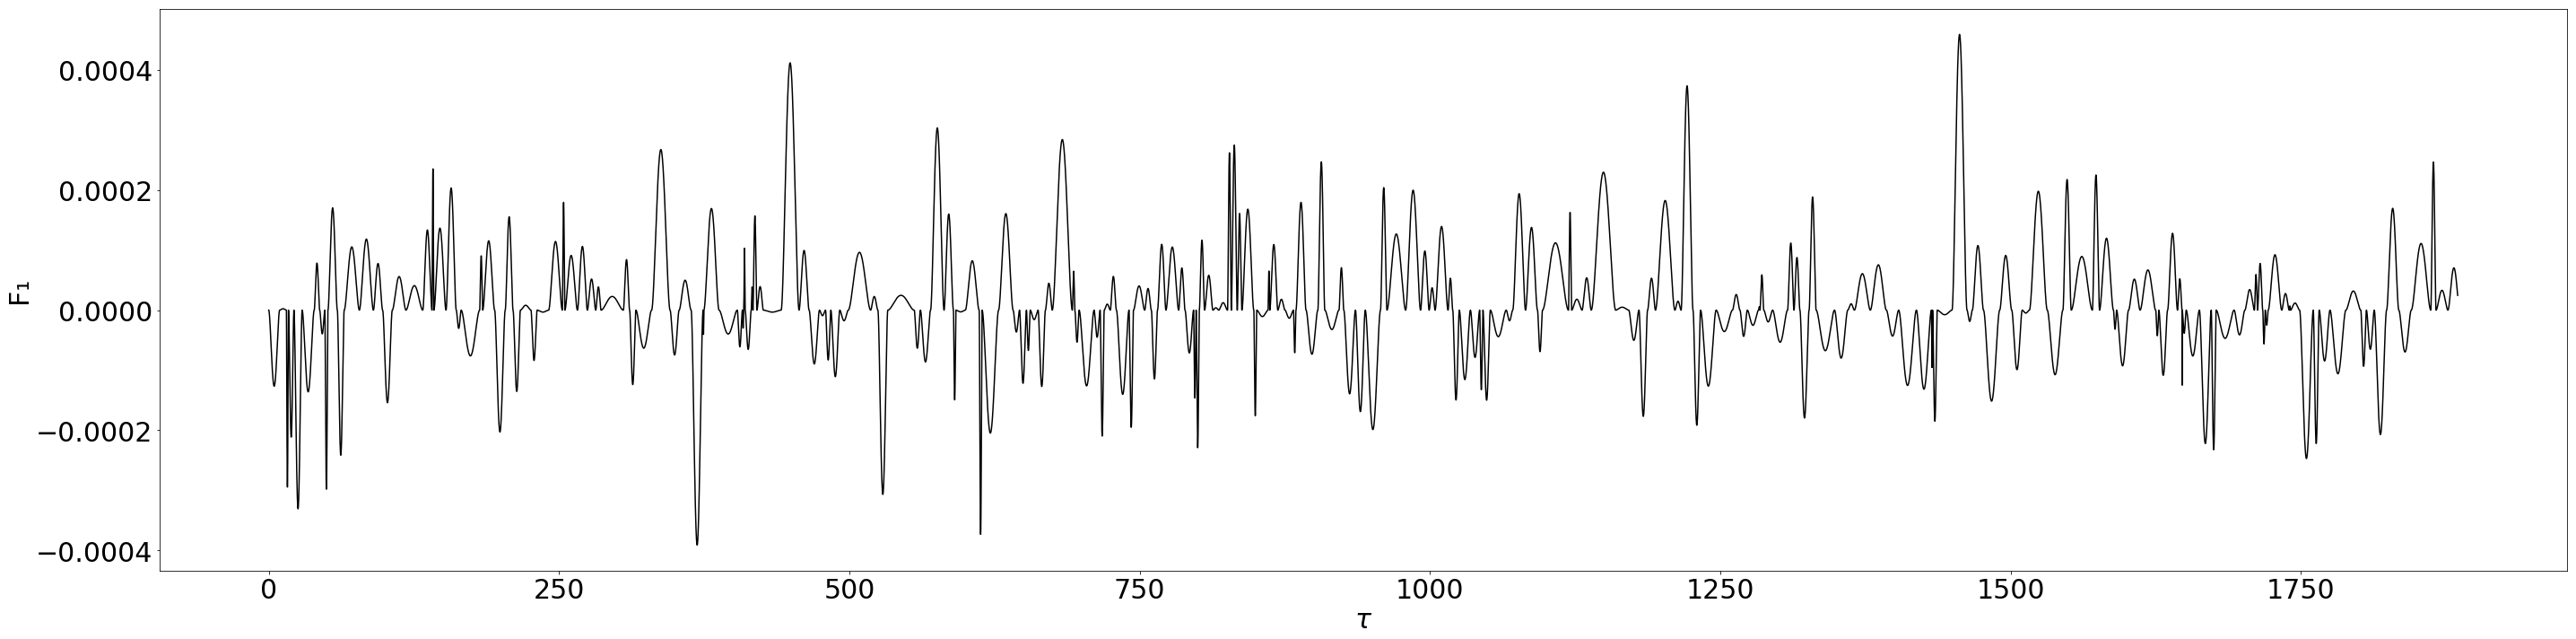

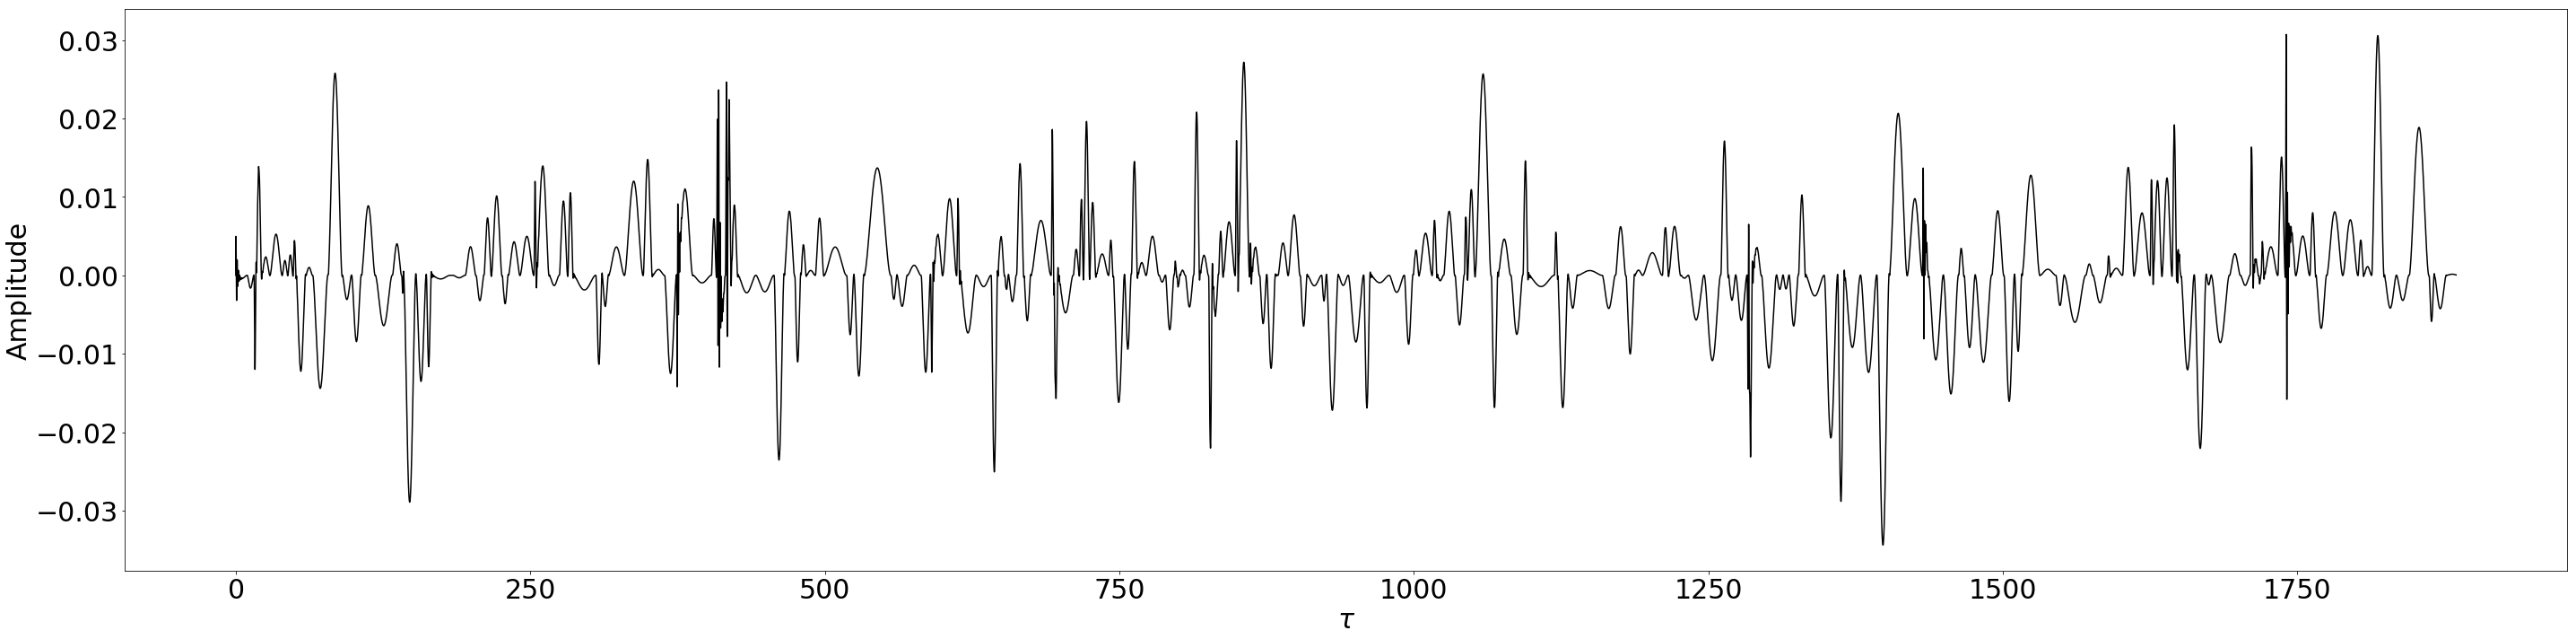

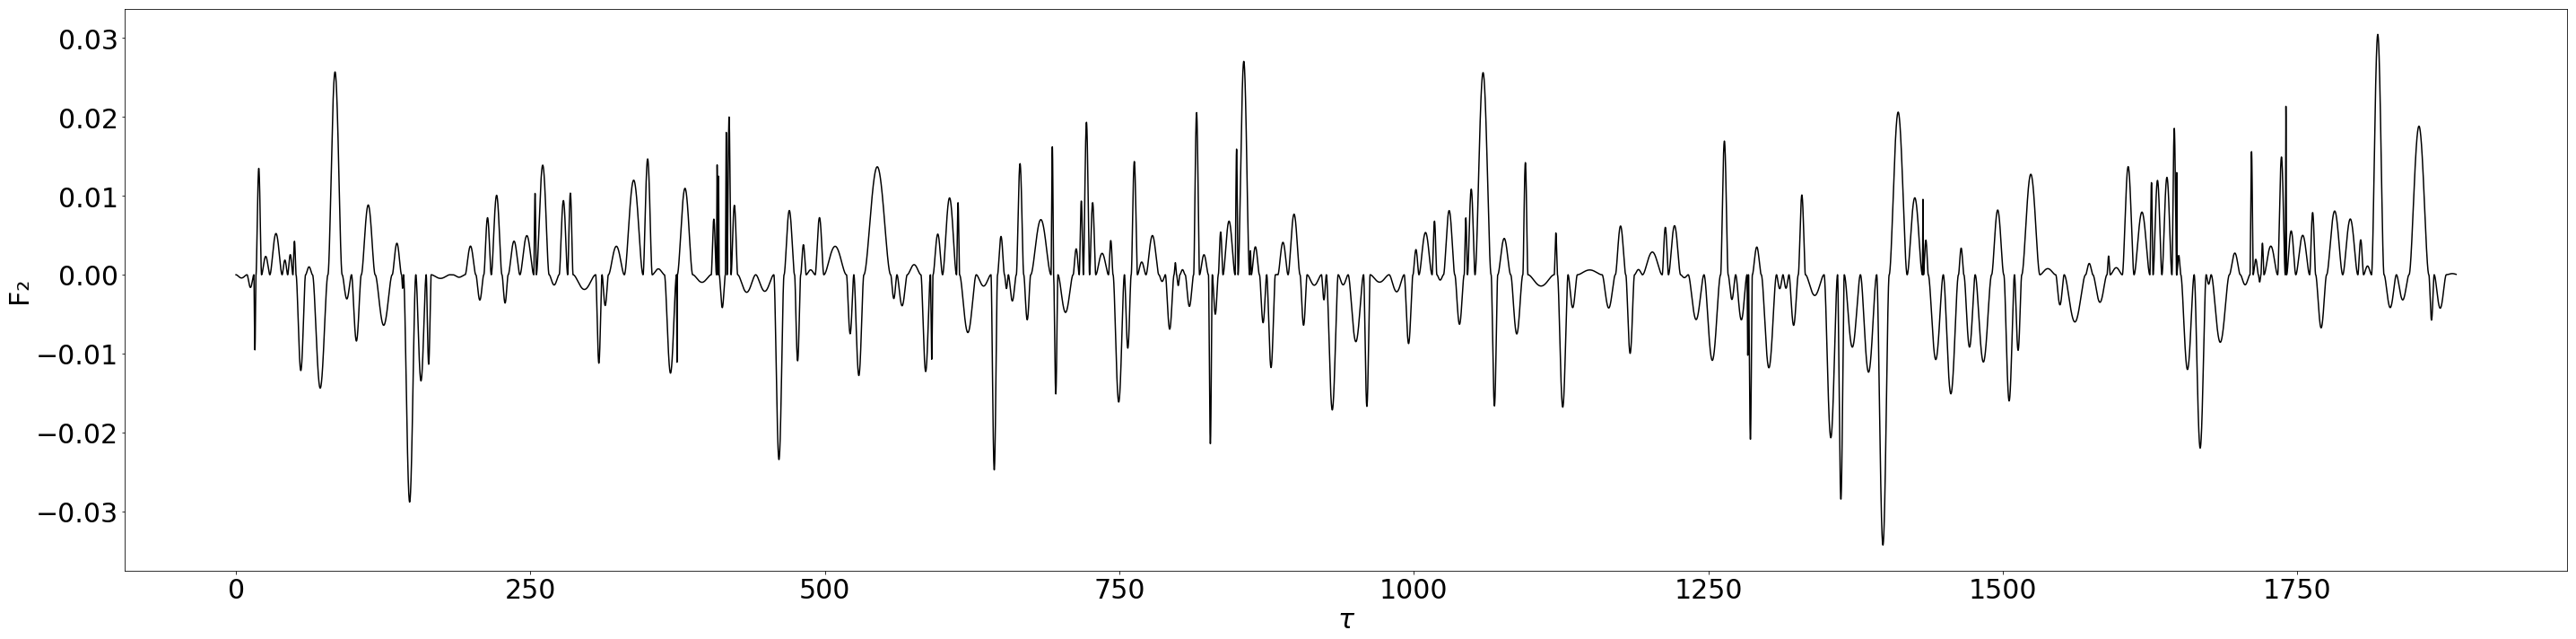

Amplitude of mode for 1000 eddy turnovers
T(max) = [7938.8799875]


In [17]:
plt.figure(figsize=(40,10))

plt.plot(time, Amp, 'k')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.ticklabel_format(style='sci', axis = 'both', scilimits=(0,0))
#plt.Axes.offsetText.set_fontsize(24)
plt.xlabel(r'$\tau$', **axis_font)
plt.ylabel('Amplitude', **axis_font)
plt.show()

tshort = []
Ashort = []
f1short = []
f2short = []
index = 0

while time[index] < 2*np.pi*300:
    tshort.append(time[index])
    Ashort.append(Amp[index])
    f1short.append(F1[index])
    f2short.append(F2[index])
    index +=1

Funplots(tshort, Ashort, f1short, f2short)

print("Amplitude of mode for" , M, "eddy turnovers")

# T(max) is the duration of each evolution
Tmax = time[-1]
# want T(max) ~ 2*pi*10^4
# T(max) = 2*pi*M
print("T(max) =", Tmax)

## Amplification Distribution Function

In [18]:
delt = N * deltaT

### Function

In [19]:
def funAlpha(A, t, alpha):

    # root mean square of amplitude for T(max)
    Abar_max = FunRMS(A)

    # the number of time segments is the total time (Tmax)/delT
    numsegments = int(Tmax/int(sum(delt)/len(delt)))+1

    # 2d array containing an array for amplitudes in each segments
    ampsegments = []

    # this loop divides the total duration T(max) into equal segments of delT
    # and adds corresponding amplitudes in each time segment to amsegments 
    i=0
    for count in range(0, numsegments):
        # amp segment contains the amplitudes in the specified time segment
        ampsegment = []
        # checks if that time is withint the correct time segment
        while i < len(t)-1:
            if (t[i] < (count+1)*2*np.pi):
                # adds the corresponding amplitude if the time is within specified time segment
                ampsegment.append(A[i])
                i+=1
            else:
                # breaks the while loop if the time is outside the time segment 
                # and moves to the next time segment
                break        
        ampsegments.append(ampsegment)


    # take Abar(T) = rms(A in delT)
    # Abar is the root mean square (RMS) of A in delT   
    Abar = []    
    for ampsegment in ampsegments:
        Abar.append(FunRMS(ampsegment))

    # in order to better exhibit the distribution of the full range of values of Abar, use instead
    # alpha = log(Abar) so -4 <= alpha <= 0
    tempalpha = FunLog(Abar)
    alpha.append(tempalpha)

    alpha_max = max(tempalpha)
    alpha_min = min(tempalpha)
    
    return alpha

def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

evolution 1 above
evolution  2


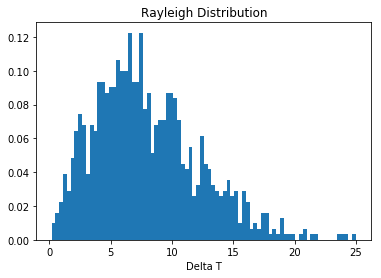

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.
/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


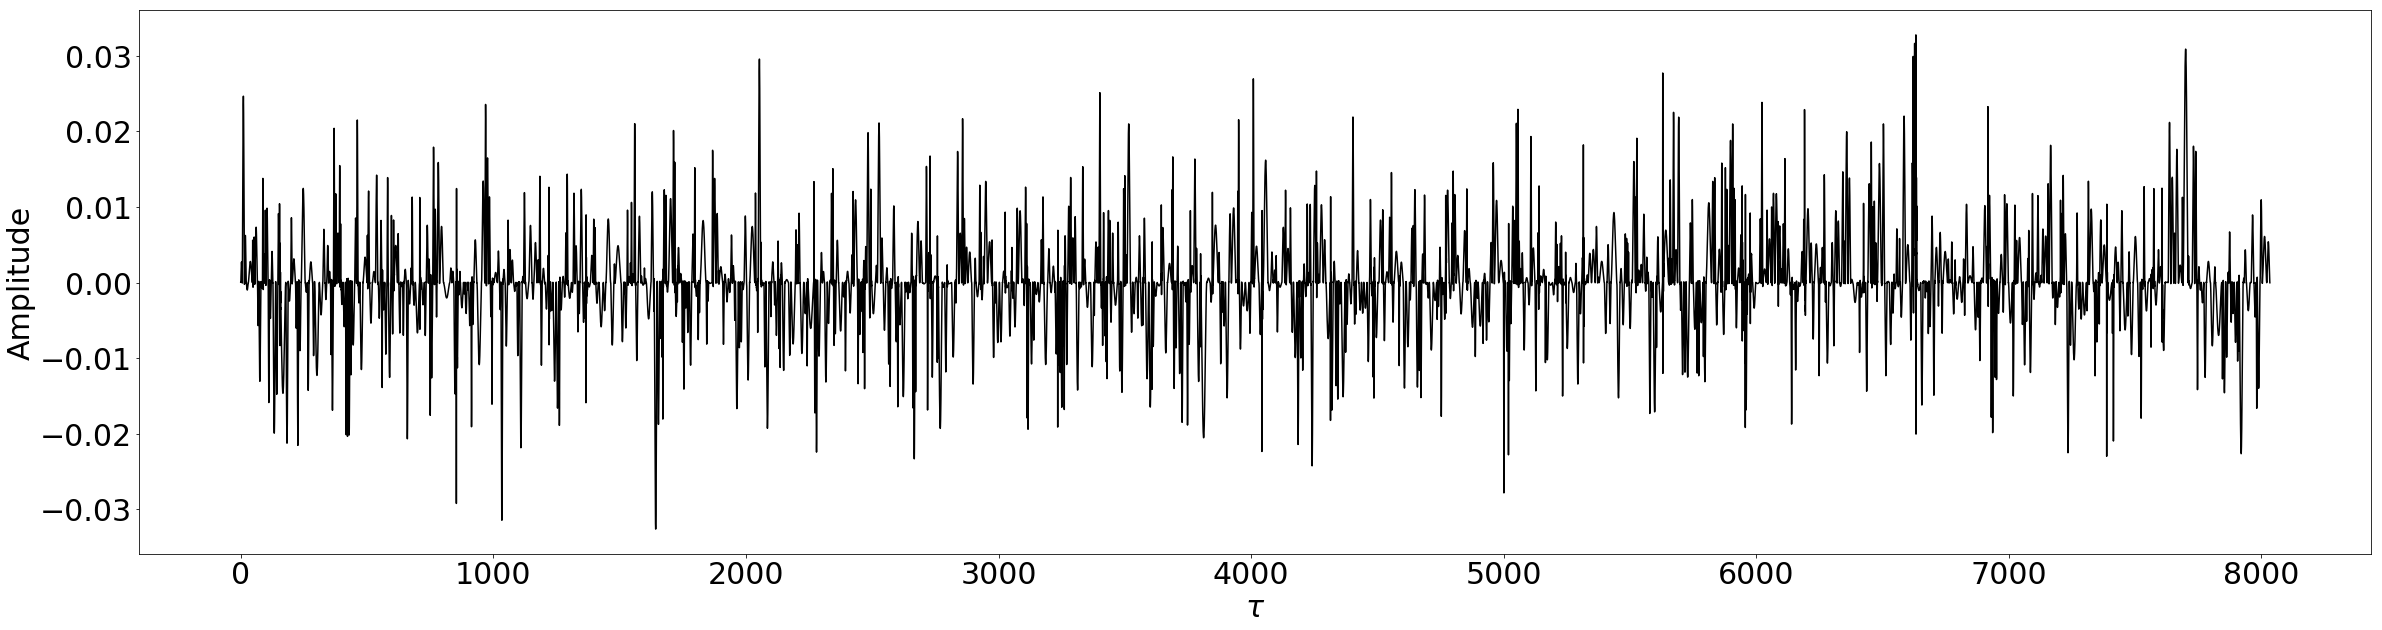



evolution  3


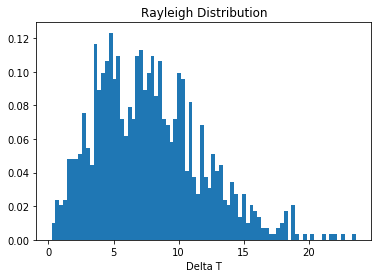

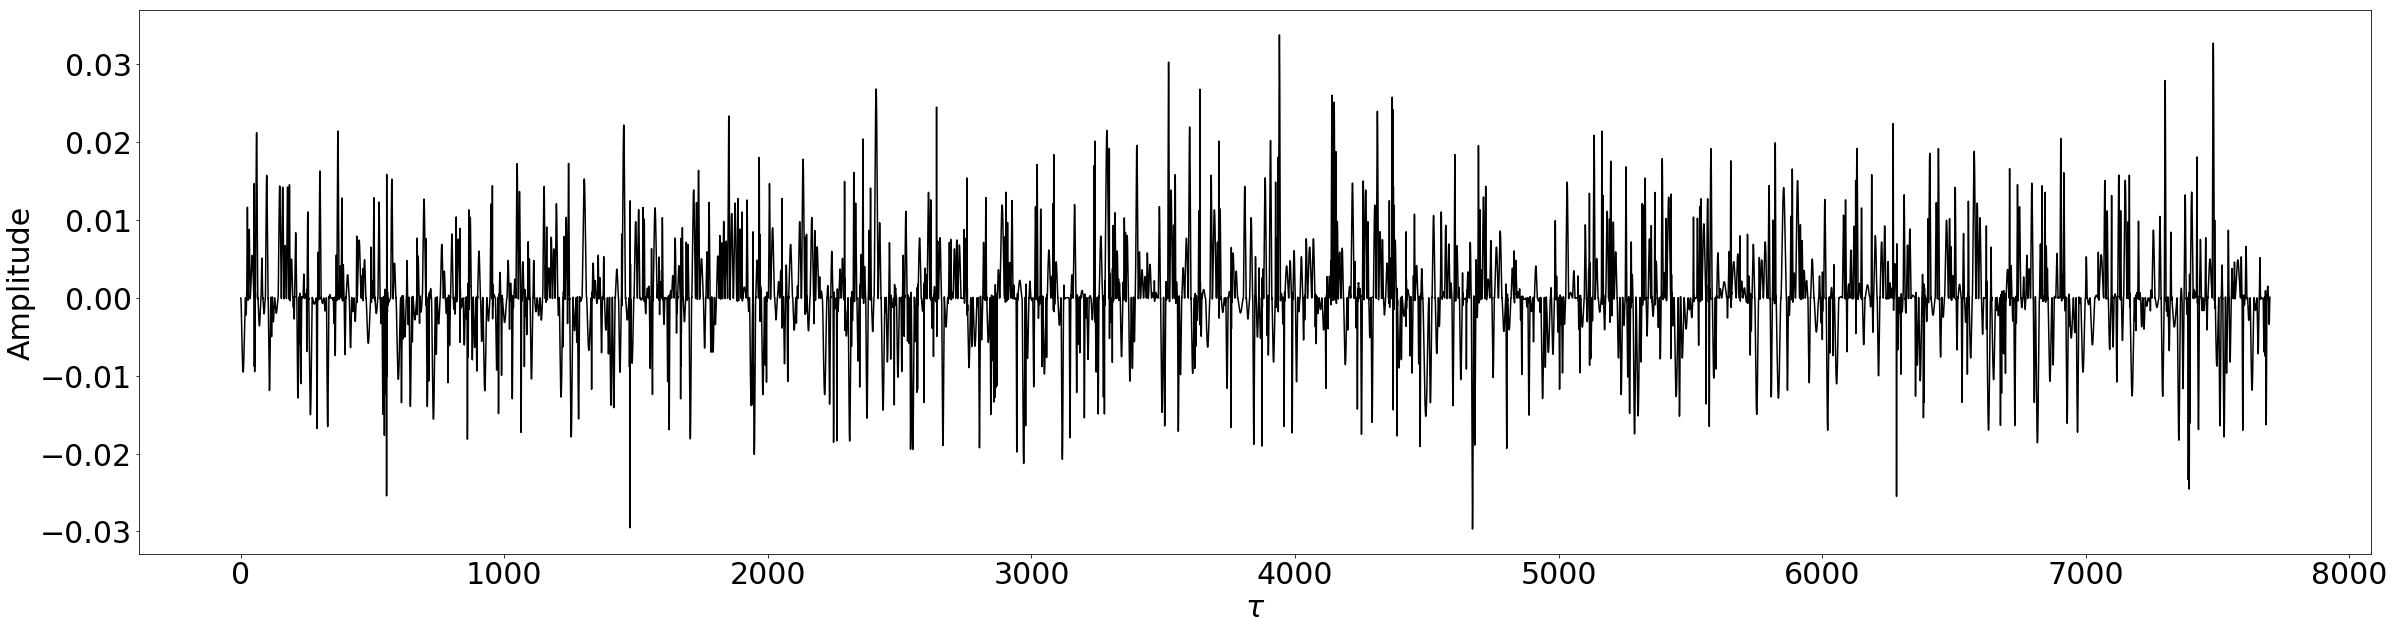



evolution  4


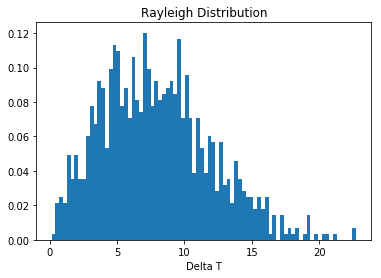

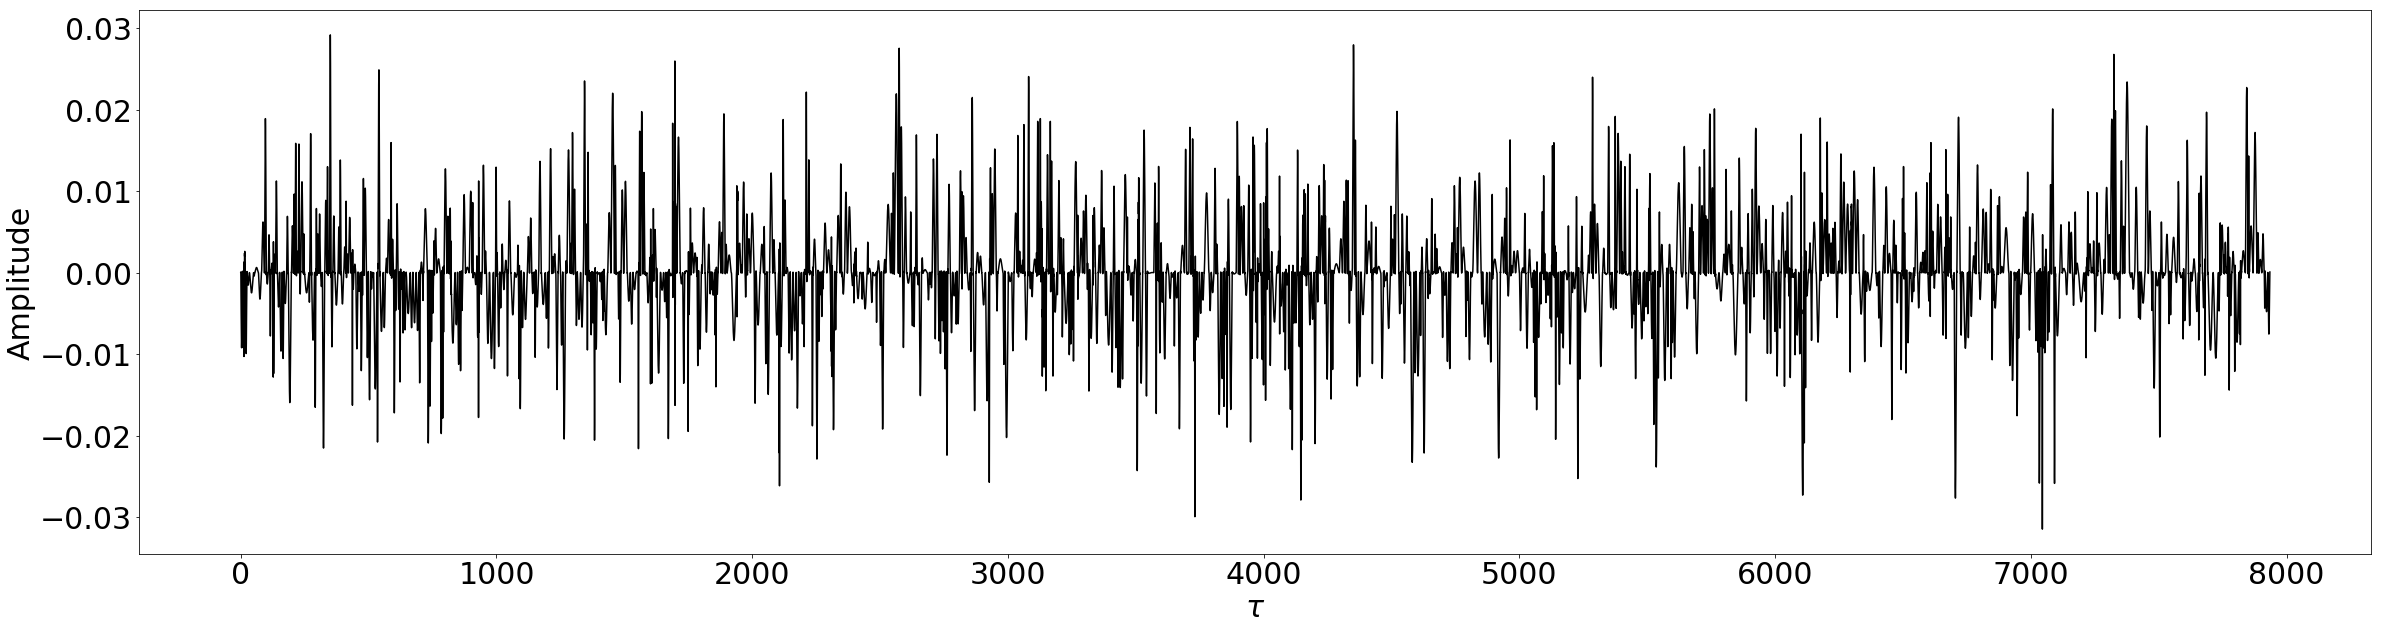



evolution  5


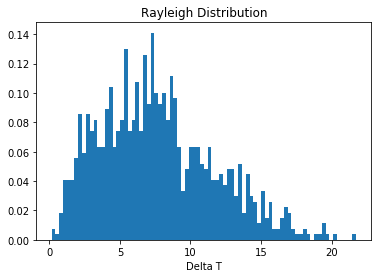

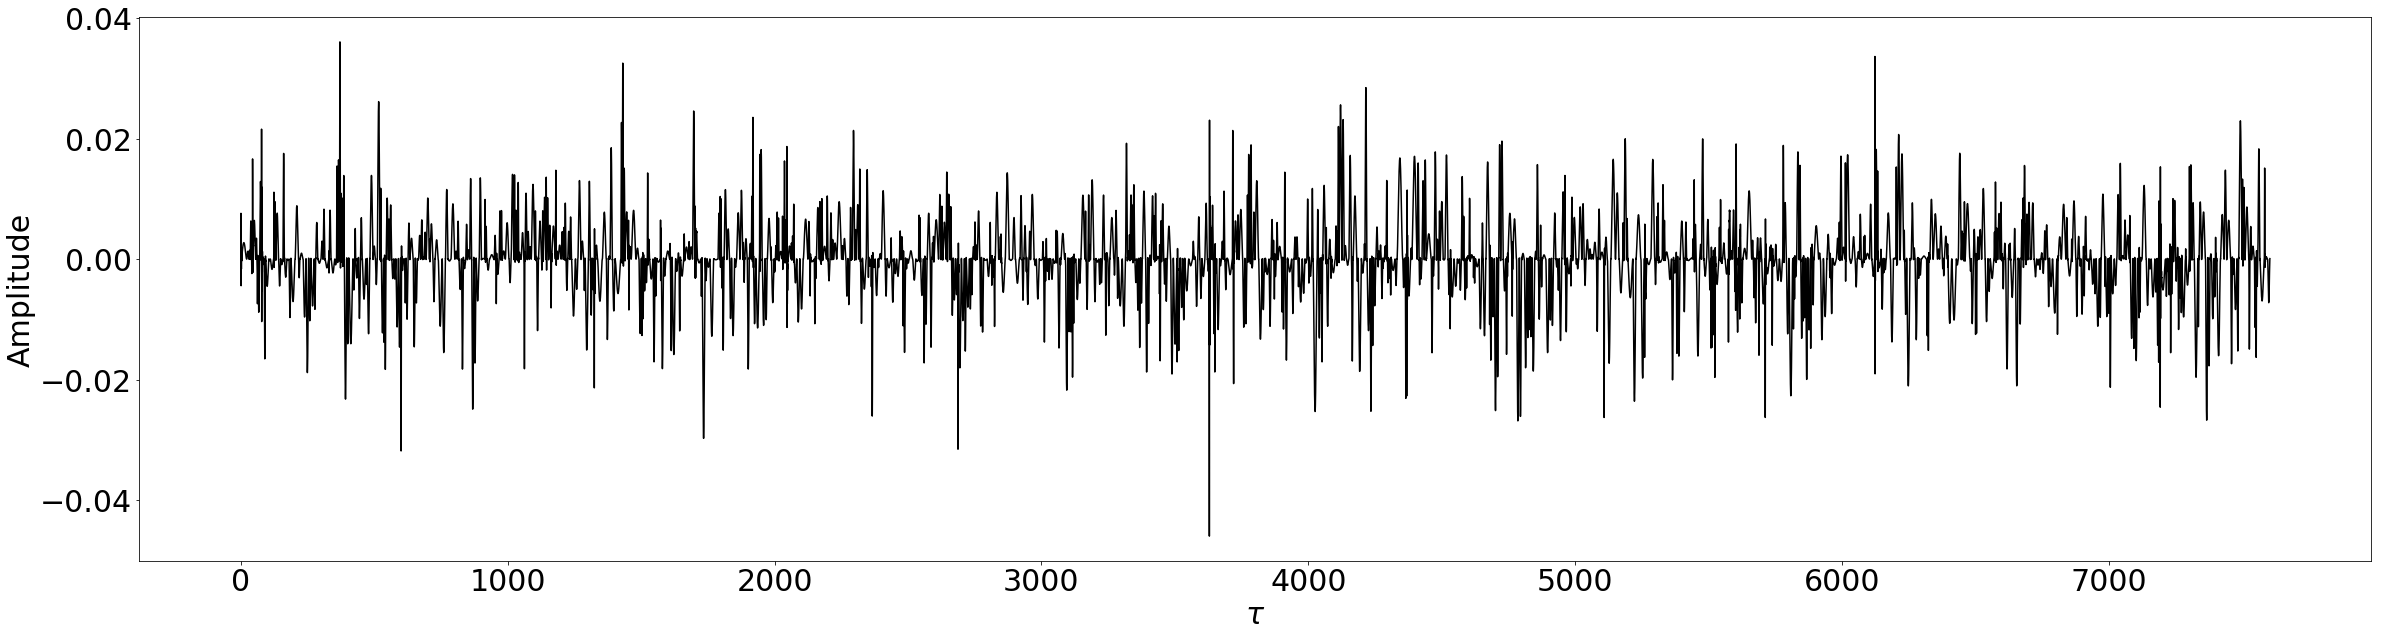



evolution  6


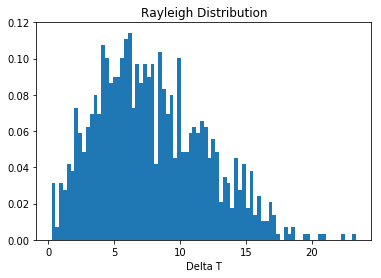

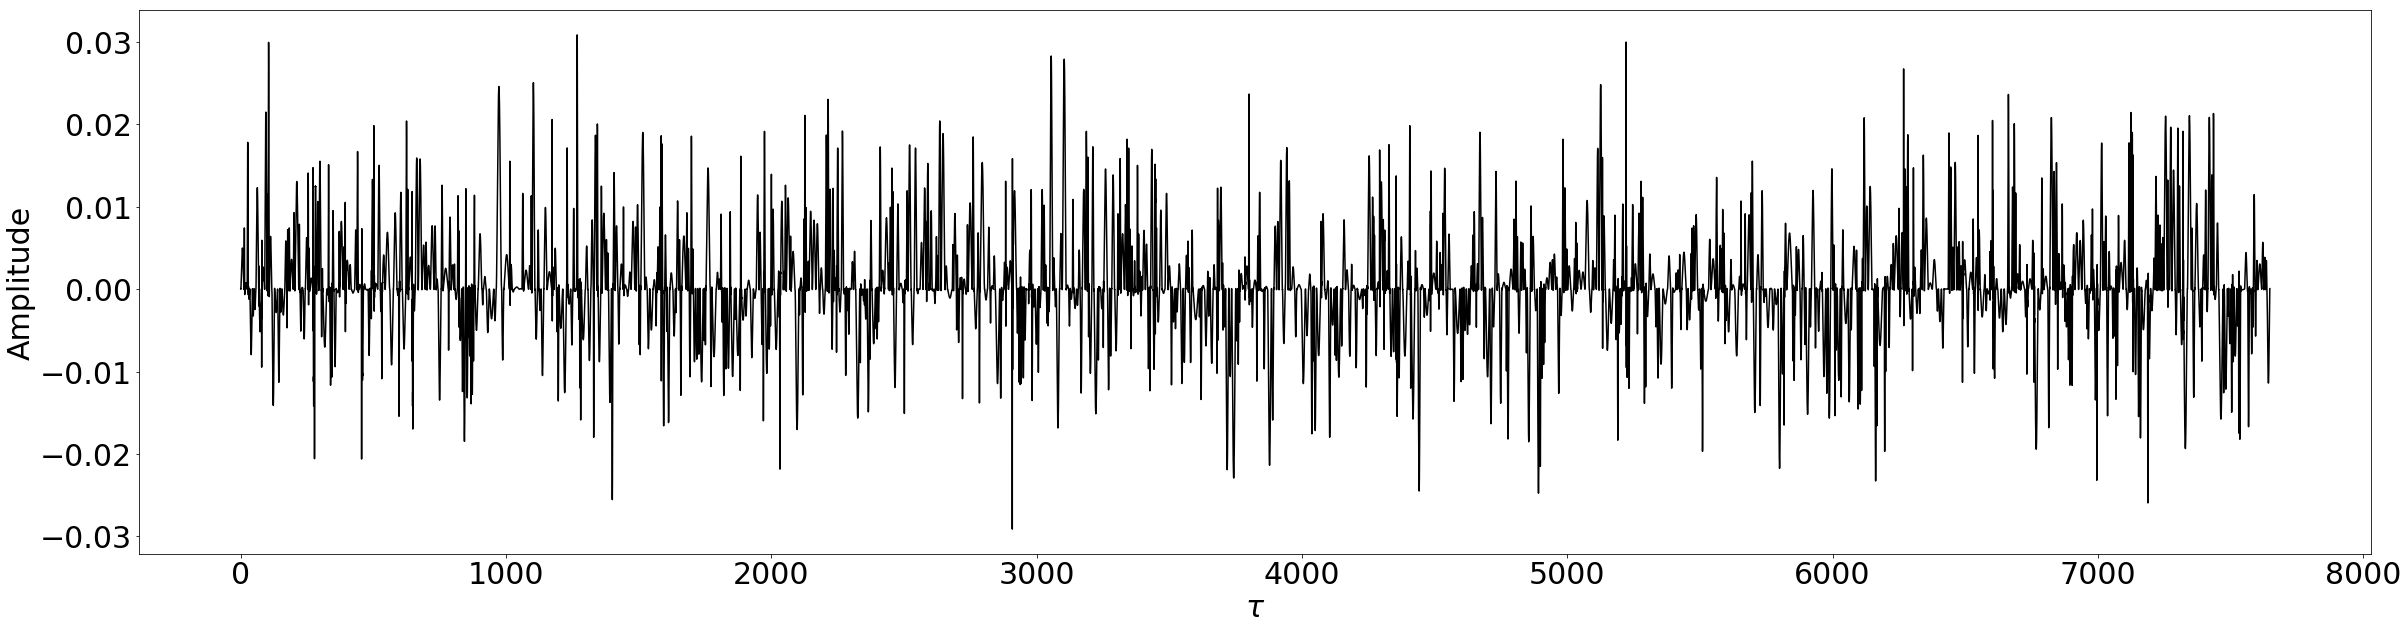



evolution  7


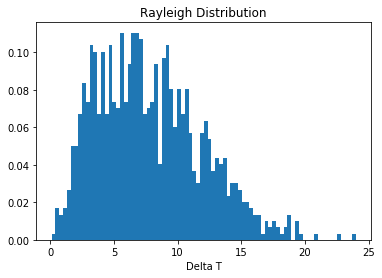

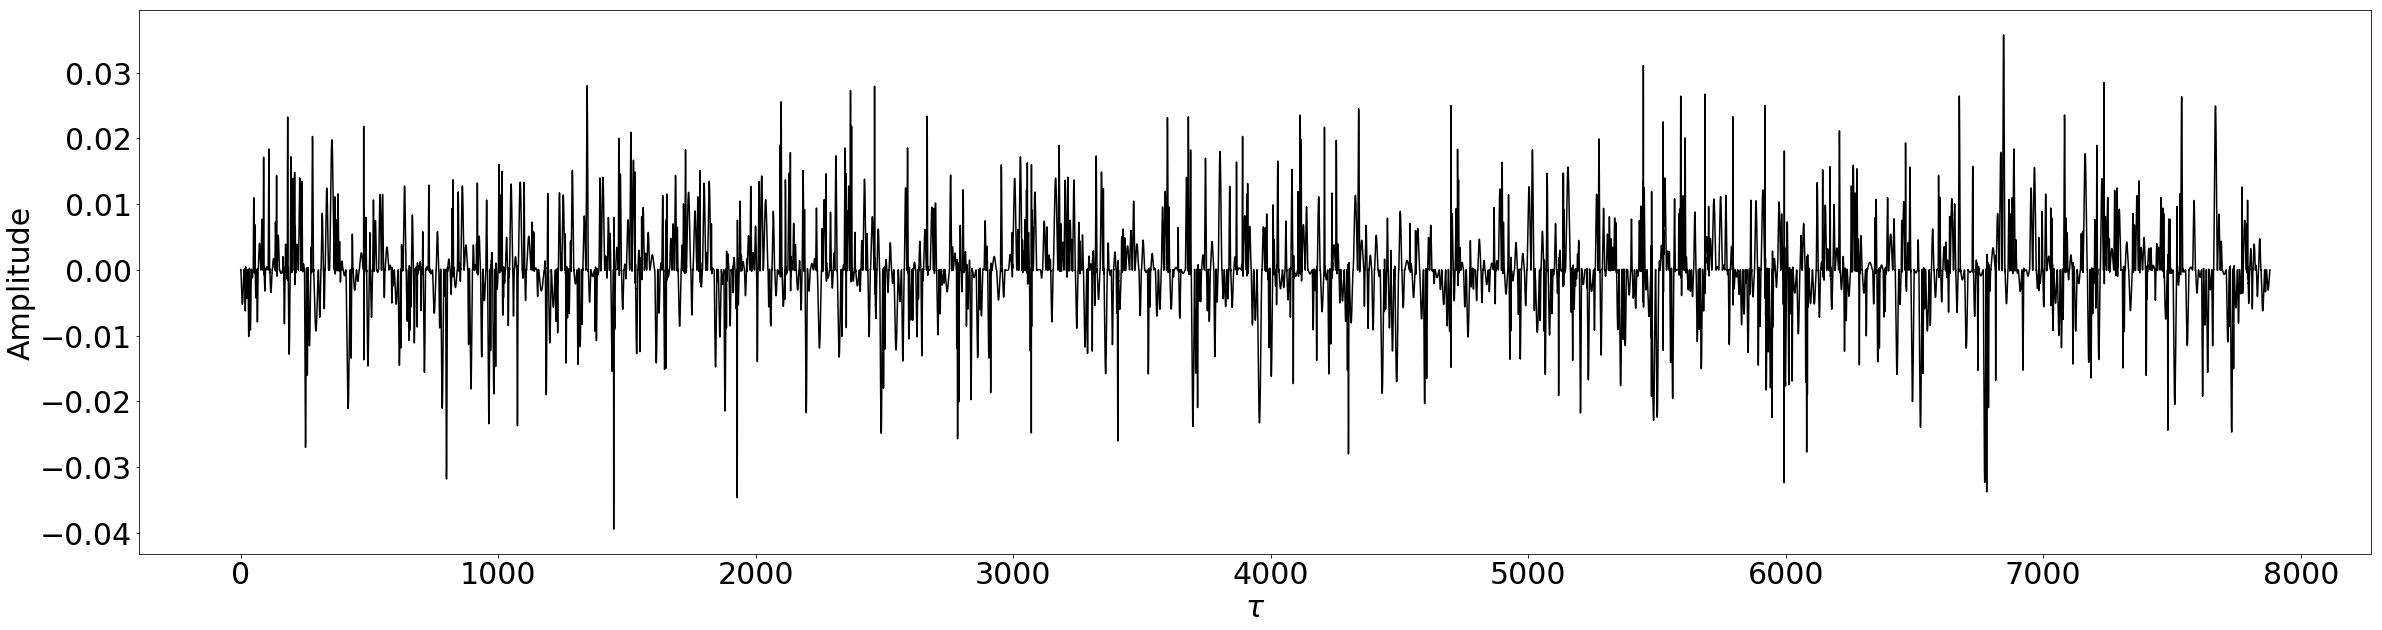



evolution  8


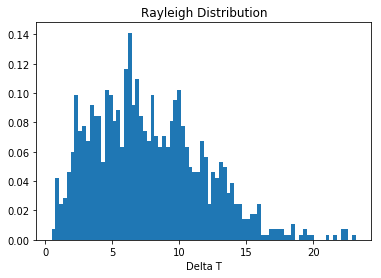

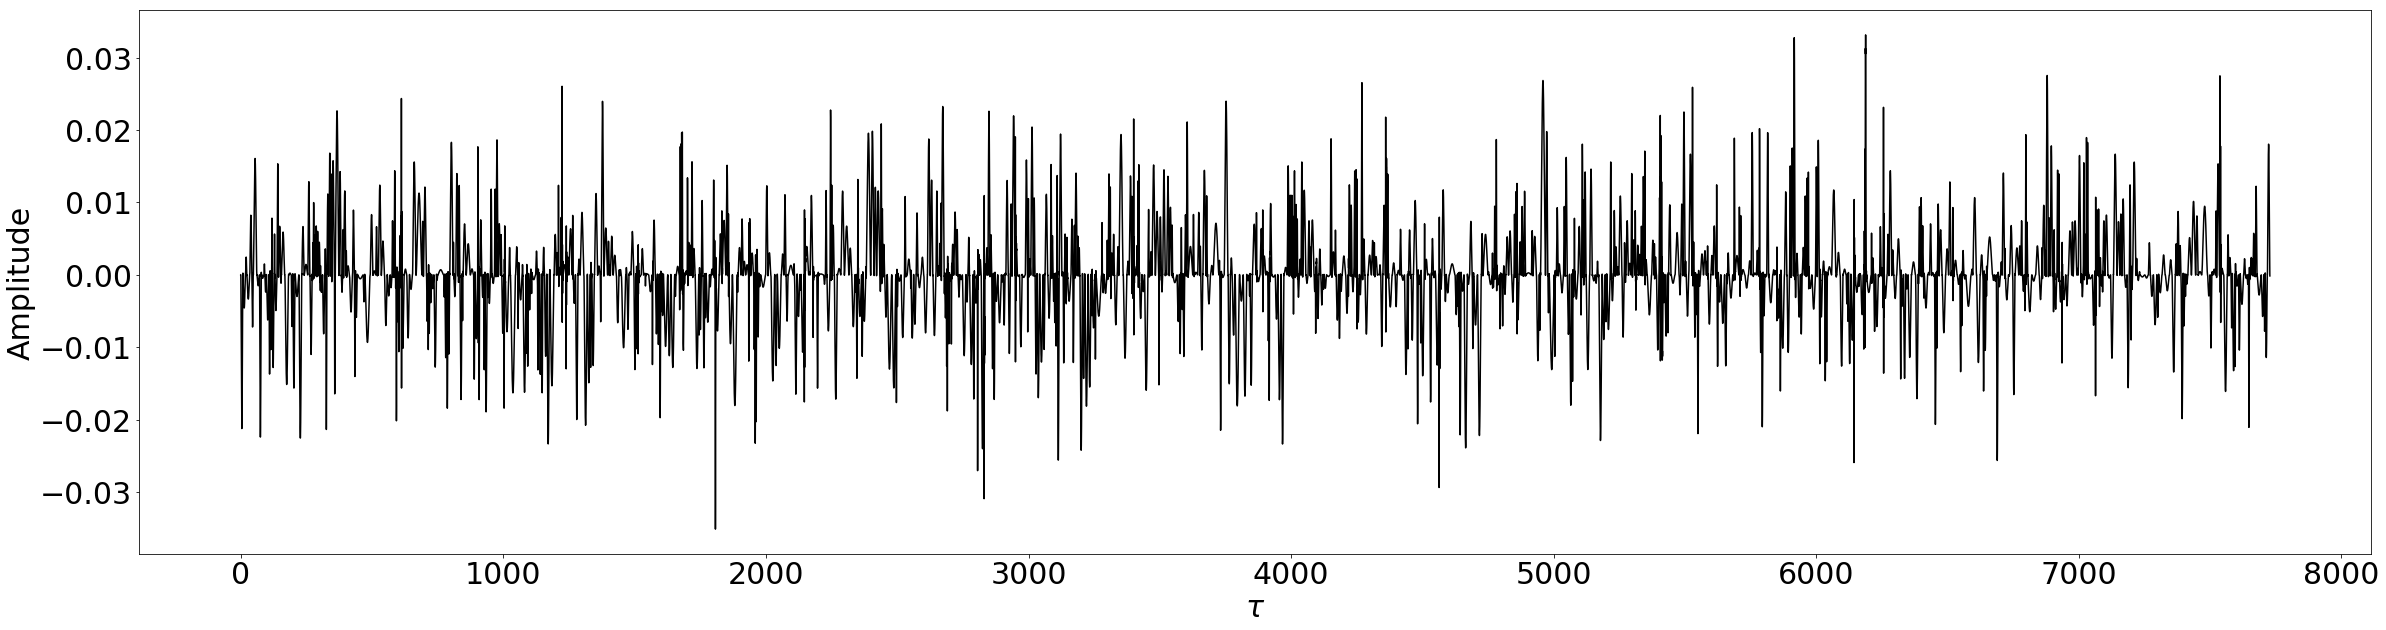



evolution  9


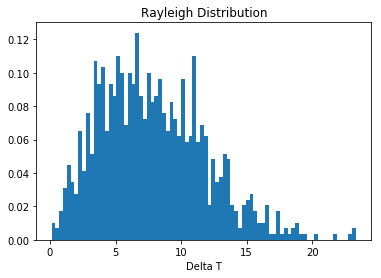

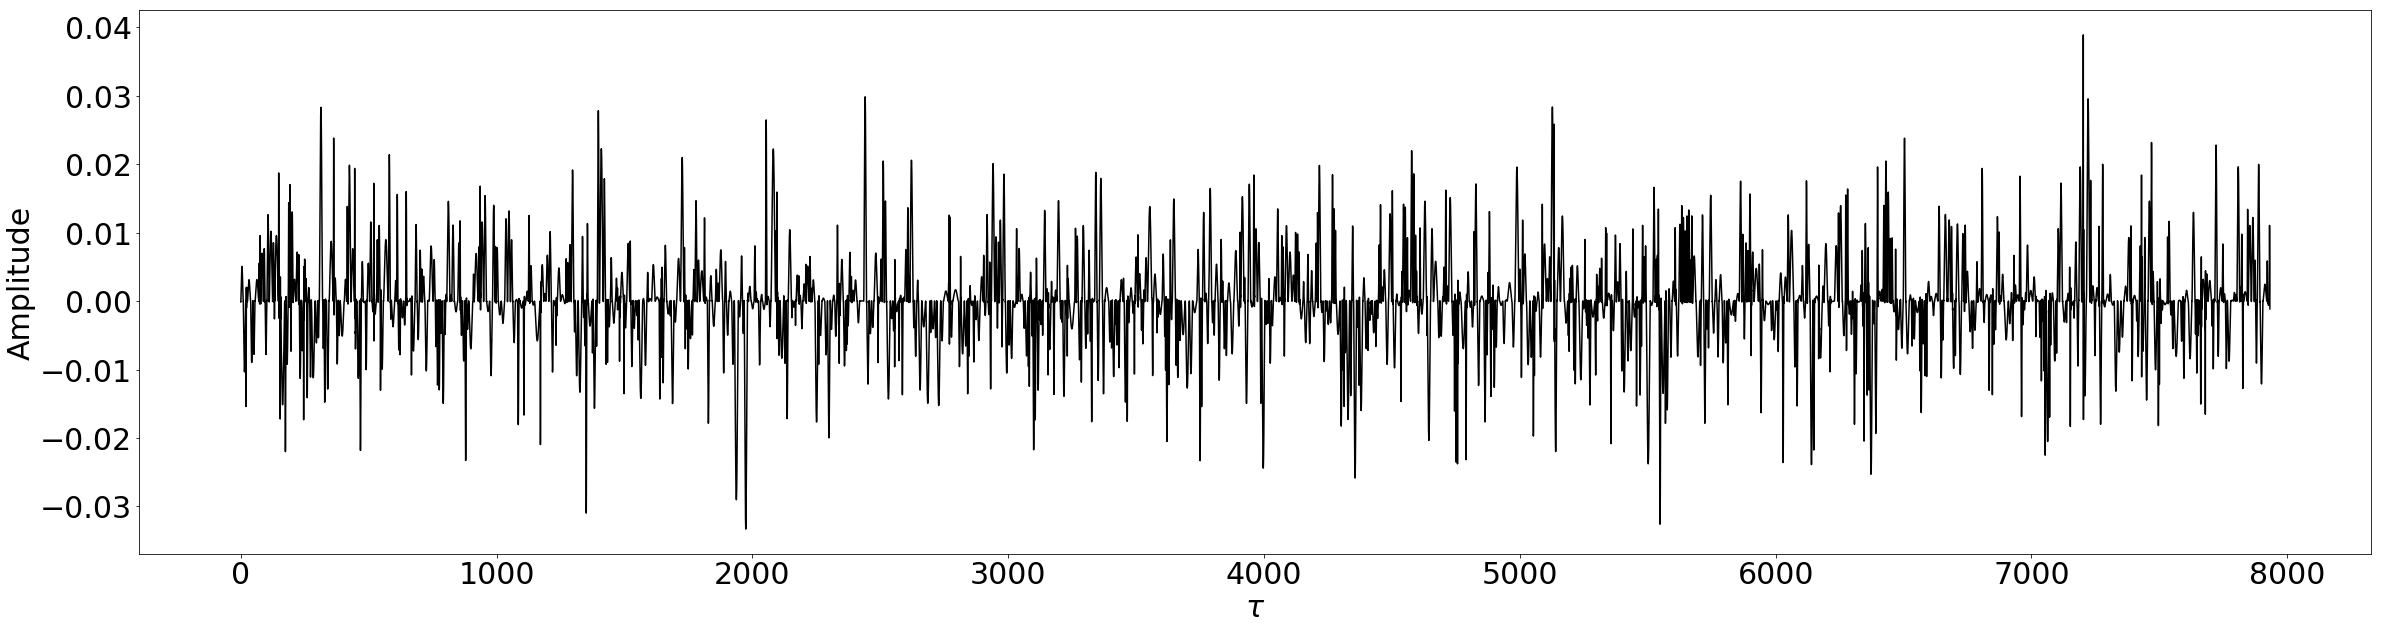



evolution  10


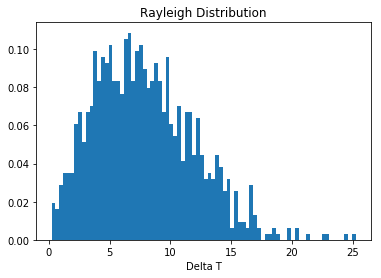

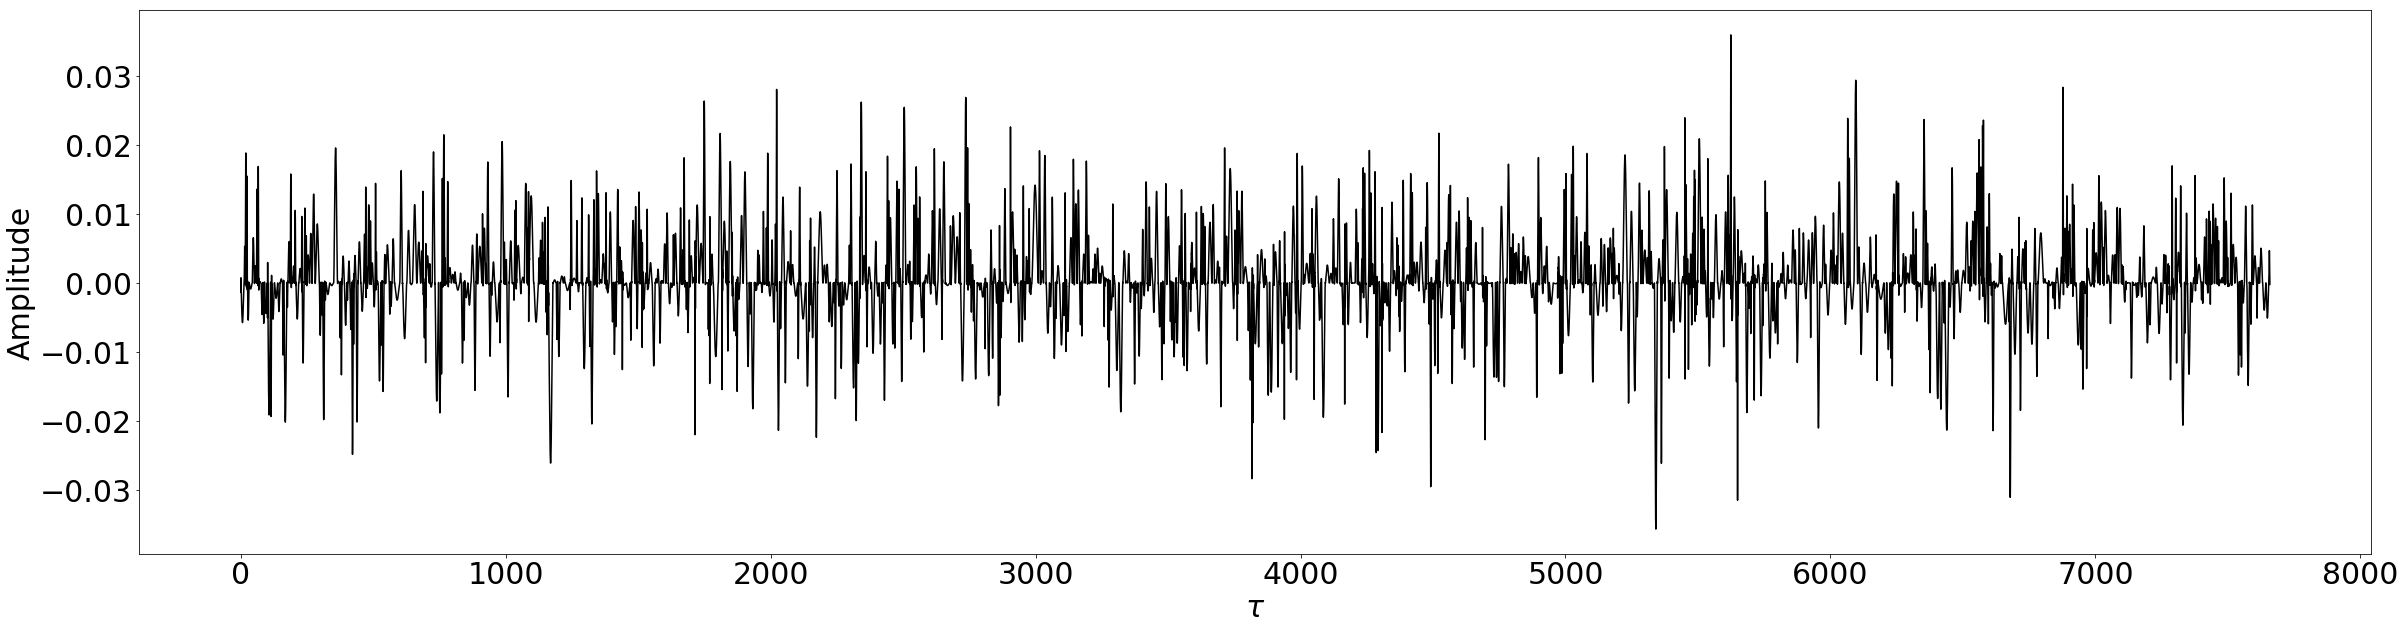

In [20]:
alpha = []
funAlpha(Amp, time, alpha)

print("evolution 1 above")
# collecting nmax values of alpha from L evolutions
for i in range(L-1):
    print("evolution ", i+2)
    deltaT = fundeltaT(n_bins, M)
    Tturb, time = funTturb()
    F2, time = funF2()
    F1, time =funF1()
    G1 = funG1(F1)
    Amp=[]
    for i in range(len(time)):
        m1 = u
        k1 = -(F1[i] * u) - A + F2[i]
        m2 = u + (h / 2.) * k1
        t_2 = t + (h / .2)
        A_2 = A + (h / .2) * m1
        u_2 = m2
        k2 = -(F1[i] * u_2) - A_2 + F2[i]
        m3 = u + (h / .2) * k2
        t_3 = t + (h / .2)
        A_3 = A + (h / .2) * m2
        u_3 = m3
        k3 = -(F1[i] * u_3) - A_3 + F2[i]
        m4 = u + h *k3
        t_4 = t + h
        A_4 = A + h * m3
        u_4 = m4
        k4 = -(F1[i] * u_4) - A_4 + F2[i]
        t = t + h 
        A = A + (h / 6.) * (m1 + (2. * m2) + (2. * m3) + m4)
        u = u + (h / 6.) * (k1 + (2. * k2) + (2. * k3) + k4)
        Amp.append(A)
    plt.figure(figsize=(40,10))
    plt.plot(time, Amp, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.show()
    funAlpha(Amp, time, alpha)
    print("\n")

alpha = flatten(alpha)


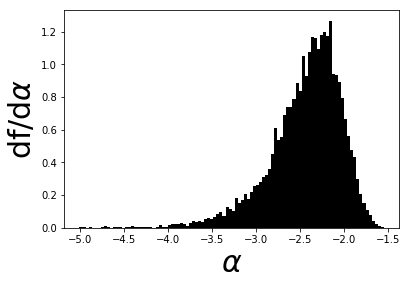

In [21]:
# divide the full range alpha_min <= alpha <= alpha_max into n equal intervals
# delalpha = (alpha_max - alpha_min) / n ~ 4/n

n = 100
alpha_max = max(alpha)
alpha_min = min(alpha)
delalpha = (alpha_max - alpha_min) / n

# we want n(max) << number of samples = L * T(max)/delT = L * M / N
nmax = L * M / N

# plot delf / delalpha vs. alpha
# where delf is the fraction of collected values of alpha within each bin of width delalpha

histogram = plt.hist(alpha, n, density=True, color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('df/d'r'$ \alpha $', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

## Cumulative Distribution Function

In [ ]:
# CDF2 = int (df/dalpha) wrt dalpha from alpha to alpha_max
#      = 1 - CDF1
#      = 1 - int (df/dalpha) wrt dalpha from alpha_min to alpha

CDF2 = []
CDF1 = []

# alpha and dfdalpha values pulled from histogram above
alpha_values = histogram[1]
dfdalpha = histogram[0]
alpha_values = np.delete(alpha_values, 0)

index_max = len(alpha_values)-1

for index in range(len(dfdalpha)):
    index_start = index
    sum = 0
    for index_current in range(index_start, index_max):
        sum += dfdalpha[index_current] * alpha_values[index_current]
    CDF2.append(1-sum)
    CDF1.append(sum)
    
normalization_factor = CDF2[0]

CDF2_norm = []
for value in CDF2:
    CDF2_norm.append(value/normalization_factor)
    
CDF1_norm = []
for value in CDF1:
    CDF1_norm.append((value/normalization_factor)+1)
    
CDF2_norm = np.array(CDF2_norm)
CDF1_norm = np.array(CDF1_norm)

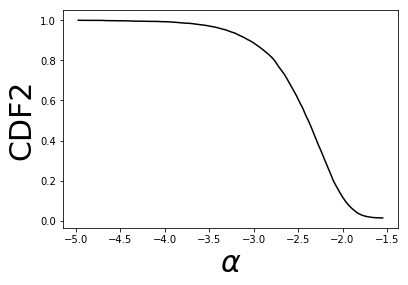

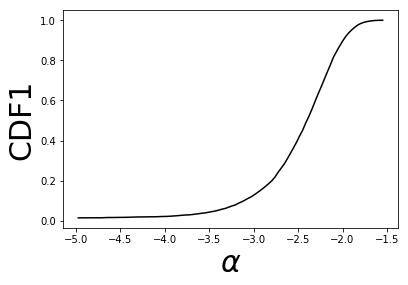

In [ ]:
plt.plot(alpha_values, CDF2_norm,  color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('CDF2', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

plt.plot(alpha_values, CDF1_norm,  color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('CDF1', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

## Duty Cycle

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def duty_cycle(CDF2_norm, k):
    # finds where CDF2 = 1/2
    CDF2_median = find_nearest(CDF2_norm, 1/2)
    index_median =  np.where(CDF2_norm == CDF2_median)

    # finds alpha star
    alpha_star = alpha_values[index_median[0]]

    # finds CDF2(alpha_star + log(k))
    # alpha find is alpha_star+log(k)
    alpha_find = find_nearest(alpha_values, alpha_star + math.log(k, 10))
    index_find = np.where(alpha_values == alpha_find)
    
    psi = CDF2_norm[index_find]

    print("psi(", k, ") =", psi)

duty_cycle(CDF2_norm, 1)
duty_cycle(CDF2_norm, 5)

psi( 1 ) = [0.49384596]
psi( 5 ) = [0.01779338]
